In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Yelp Restaurant Review - NLP Analysis

In [3]:
#checking the current working directory
!pwd

/Users/qinhuijie/Desktop/5100Project


## Data Preparation

In [4]:
import pandas as pd
import seaborn as sns
%pylab inline
import requests, re
import pandas as pd
import seaborn as sns
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


### Clean Yelp_business dataset 

In [8]:
company = pd.read_csv('yelp_business.csv')

#glimpse for a while
company.head()
company.tail()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
174562,ALV5R8NkZ1KGOZeuZl3u0A,"""Whitby Toyota""",NaN,"""1025 Dundas Street W""",Whitby,ON,L1P 1Z1,43.873460,-78.968033,4.0,4,1,Car Dealers;Automotive
174563,gRGalHVu6BcaUDIAGVW_xQ,"""Village Auto Body""",NaN,"""3957 Brecksville Rd""",Richfield,OH,44286,41.243385,-81.636212,5.0,3,1,Body Shops;Automotive
174564,XXvZBIHoJBU5d6-a-oyMWQ,"""AAM""",NaN,"""1600 W Broadway Rd, Ste 200""",Tempe,AZ,85282,33.407914,-111.965098,1.5,19,1,Home Services;Property Management;Real Estate
174565,lNpPGgM96nPIYM1shxciHg,"""Bronze Beauty Spray Tanning""",NaN,"""300 Camp Horne Rd, Ste 250""",Pittsburgh,PA,15202,40.517724,-80.091466,5.0,14,1,Spray Tanning;Tanning;Beauty & Spas
174566,viKaP26BcHU6cLx8sf4gKg,"""Phoenix Pharmacy""",NaN,"""1701 East Thomas Rd, Ste 105""",Phoenix,AZ,85016,33.479861,-112.044689,5.0,4,1,Drugstores;Shopping;Health & Medical


In [9]:
## remove unnecessary features.(latitude longtitude,is_open,'neighborhood'，‘postal_code’)
company.drop(['neighborhood'], axis=1, inplace=True)
company.drop(['postal_code'], axis=1, inplace=True)
company.drop(['latitude'], axis=1, inplace=True)
company.drop(['longitude'], axis=1, inplace=True)
company.drop(['is_open'], axis=1, inplace=True)

## remove quotation marks in name and address column
company.name=company.name.str.replace('"','')
company.address=company.address.str.replace('"','')

## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=company.loc[company['state'].isin(states)]
company.tail()

,business_id,name,address,city,state,stars,review_count,categories
174562,ALV5R8NkZ1KGOZeuZl3u0A,Whitby Toyota,1025 Dundas Street W,Whitby,ON,4.0,4,Car Dealers;Automotive
174563,gRGalHVu6BcaUDIAGVW_xQ,Village Auto Body,3957 Brecksville Rd,Richfield,OH,5.0,3,Body Shops;Automotive
174564,XXvZBIHoJBU5d6-a-oyMWQ,AAM,"1600 W Broadway Rd, Ste 200",Tempe,AZ,1.5,19,Home Services;Property Management;Real Estate
174565,lNpPGgM96nPIYM1shxciHg,Bronze Beauty Spray Tanning,"300 Camp Horne Rd, Ste 250",Pittsburgh,PA,5.0,14,Spray Tanning;Tanning;Beauty & Spas
174566,viKaP26BcHU6cLx8sf4gKg,Phoenix Pharmacy,"1701 East Thomas Rd, Ste 105",Phoenix,AZ,5.0,4,Drugstores;Shopping;Health & Medical


In [10]:
## keep only korean and Japanese

## select all restaurants in USA
us_restaurants=usa[usa['categories'].str.contains('Restaurants')]

## select out 2 cuisine types of restaurants and rename the category
us_restaurants.is_copy=False
us_restaurants['category']=pd.Series()

#keep "Japanese" and "Korean" Restaurant.
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.category[:20]

4          NaN
10         NaN
14         NaN
28         NaN
29         NaN
40    Japanese
44         NaN
45         NaN
46         NaN
52         NaN
53         NaN
54         NaN
64         NaN
72         NaN
75         NaN
76         NaN
80         NaN
81         NaN
88         NaN
91         NaN
Name: category, dtype: object

In [11]:
## drop null values in category, delete original column categories and reset the index
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])
del us_restaurants['categories']
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,stars,review_count,category
0,tRVx2c89coruPRwYhGTcTw,Yuzu,13603 Madison Ave,Lakewood,OH,3.5,78,Japanese
1,M3uV9Y3EDSpy9d4YwyNSAQ,Yakiramen,10605 N 43rd Ave,Phoenix,AZ,4.0,66,Japanese
2,6PwKC0dqP9uI85FEP86iPQ,Red Viet Cuisine - Sushi,"5221 S Power Rd, Ste 104",MESA,AZ,3.5,164,Japanese
3,pBoWsom3mZFYo9EucIWRDg,Kabuki Sushi & Grill,"8378 W Thunderbird Rd, Ste 107",Peoria,AZ,4.0,157,Japanese
4,gEJZ5USuvC1r8_QvSvDCNA,K-Bowl,39 E Green St,Champaign,IL,3.5,50,Korean
5,SlelFNxQz5PJbl6kkjI0OA,Makino,9570 S Eastern Ave,Las Vegas,NV,3.0,7,Japanese
6,pidpBdWsOFfe7pWypBIoiQ,Miga Korean Bistro,6112 W Flamingo Rd,Las Vegas,NV,4.0,42,Korean
7,Km0sT7E_dc2U1BkyRoy1xA,"Akahana - Asian Bistro, Bar & Sushi","940 Market St, Ste 124",Fort Mill,SC,3.0,122,Japanese
8,6nxVZ1s0mRhyRAdRymYAsQ,Ichi Ban Japanese Restaurant,9897 W McDowell Rd,Tolleson,AZ,2.0,60,Japanese
9,QI0PGXbGkIdInOOBeq6ieQ,TJ Buffet Sushi and Grill,4801 McKnight Rd,Pittsburgh,PA,3.0,36,Japanese


In [12]:

## check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()


## check missing values
us_restaurants.isnull().sum()


(1333, 8)

0

business_id     0
name            0
address         0
city            0
state           0
stars           0
review_count    0
category        0
dtype: int64

### Clean yelp_review dataset

In [13]:
## load review table
review = pd.read_csv('yelp_review.csv')
review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [14]:
## check missing values
review.isnull().sum()

## check duplicates of review_id
review.review_id.duplicated().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

0

### Merge two datasets and get new dataframe restaurants_reviews
### Import two sentimental dictionary that we need later(positive.txt and negative.txt)

In [15]:
## merge business table and review table
restaurants_reviews = pd.merge(us_restaurants, review, on = 'business_id')

## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

In [17]:
# label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >3, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neural'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)


In [18]:
#import positive and negative dictionary
import csv 
file_positive = open('positive.txt','r', encoding="ISO-8859-1")
reader =csv.reader(file_positive)

positive = [];
for word in reader:
    positive.append(word[0])


file_negative = open('negative.txt','r', encoding="ISO-8859-1")
reader =csv.reader(file_negative)    
    
negative = [];
for word in reader:
    negative.append(word[0])


In [19]:
#check first 10 positive words
positive[1:10]

['abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation',
 'accolade']

## Review Analysis

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)


In [21]:
## Cleaning
## convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews.loc[:,'removed_punct_text'] = restaurants_reviews.text.str.replace('\n','')
restaurants_reviews.loc[:,'removed_punct_text'] = restaurants_reviews.text.str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')


### Korean Restaurant


In [29]:
#filter out the data which has category equals to "Korean"
Korean_reviews = get_dataset('Korean')

In [30]:
Korean_train, Korean_test = train_test_split(Korean_reviews[['text','labels']],test_size=0.5)

In [31]:
## filter words
## get rid of stop words(the,a,an...)
## only keep positive && negative words

Korean_train.text = Korean_train.text.apply(filter_words) 
# filter_words is a helper function which can be founded at last.


In [32]:
## construct features and labels
terms_train=list(Korean_train['text'])
class_train=list(Korean_train['labels'])

terms_test=list(Korean_test['text'])
class_test=list(Korean_test['labels'])

In [33]:
## get bag of words : the frequencies of various words appeared in each review
vectorizer = CountVectorizer()
feature_train_counts=vectorizer.fit_transform(terms_train)
feature_train_counts.shape

(17343, 2718)

In [34]:
## run model
svm = LinearSVC()
svm.fit(feature_train_counts, class_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

### Now we can calculate polarity score of each word in the specific category

In [35]:
## create dataframe for score of each word in a review calculated by svm model
coefficient= svm.coef_[0]
Korean_words_score = pd.DataFrame({'score': coefficient, 'word': vectorizer.get_feature_names()})

In [36]:
## get frequency of each word in all reviews in specific category
Korean_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
Korean_reviews['labels'] = class_train
Korean_frequency = Korean_reviews[Korean_reviews['labels'] =='positive'].sum()[:-1]

In [37]:
Korean_words_score.set_index('word', inplace=True)

In [38]:
Korean_polarity_score = Korean_words_score
Korean_polarity_score['frequency'] = Korean_frequency

In [39]:
## calculate polarity score 
Korean_polarity_score['polarity'] = Korean_polarity_score.score * Korean_polarity_score.frequency / Korean_reviews.shape[0]

In order to find specific words that were used to indicate
customers’ concerns for the restaurant, or by moving forward
exploring the unique characteristic of each restaurant category,
adjectives that simply describing the polarity of sentiment (i.e.
“good”, “amazing”, “terrible” and etc.) were neglected.

In [40]:
## drop unnecessary words
unuseful_positive_words = Korean_polarity_score.loc[['impressed','great','amazing','love','best','excellent','good',
                                                    'favorite','loved','gem','perfectly','wonderful','delightful',
                                                    'happy','enjoyed','nice','super','like','better','decent','fine',
                                                    'pretty','enough','excited','ready','fantastic','glad','right',
                                                    'fabulous','fun','well','fabulous','awesome','impressed']]

unuseful_negative_words =  Korean_polarity_score.loc[['bad','terrible','unfortunately','disappoint','annoyed','annoying','horrible',
                                                     'lacking','sorry', 'awful','disappointed','disappointing','angry','sad']]


Korean_polarity_score.drop(unuseful_positive_words.index, axis=0, inplace=True)
Korean_polarity_score.drop(unuseful_negative_words.index, axis=0, inplace=True)

In [41]:
Korean_polarity_score.polarity = Korean_polarity_score.polarity.astype(float)
Korean_polarity_score.frequency = Korean_polarity_score.frequency.astype(float)

In [42]:
get_top_words(Korean_polarity_score, 'positive')

,score,frequency,polarity
word,,,
delicious,0.7264,3403.0000,0.1425
friendly,0.2418,2173.0000,0.0303
perfect,0.5491,862.0000,0.0273
attentive,0.2844,904.0000,0.0148
reasonable,0.4702,527.0000,0.0143
recommend,0.1386,1750.0000,0.0140
tender,0.3400,604.0000,0.0118
solid,0.9158,219.0000,0.0116
helpful,0.4321,444.0000,0.0111


In [43]:
get_top_words(Korean_polarity_score, 'negative')

,score,frequency,polarity
word,,,
bland,-0.7158,137.0000,-0.0057
slow,-0.3598,245.0000,-0.0051
cold,-0.1576,475.0000,-0.0043
wrong,-0.2335,318.0000,-0.0043
sweet,-0.0621,1154.0000,-0.0041
work,-0.1783,390.0000,-0.0040
expensive,-0.2022,288.0000,-0.0034
hard,-0.1194,454.0000,-0.0031
overpriced,-0.6840,69.0000,-0.0027



### Get top  most informative positive and negative words
### for visualization

In [44]:
Korean5top_positive = ['delicious','perfect','friendly','attentive','reasonable']
Korean5top_negative = ['cold','slow','bland','sweet','expensive']
Korean5top = Korean_polarity_score.loc[Korean5top_positive+Korean5top_negative,'polarity']

Text(0.5,0,'Polarity Score')

Text(0,0.5,'Words')

Text(0.5,1,'TOP 5 Positive and Negative Words in Korean Restaurants')

(array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,
         0.16]), <a list of 10 Text xticklabel objects>)

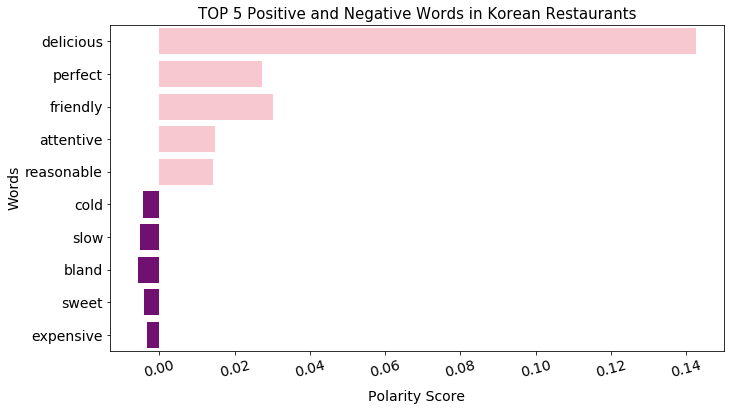

In [45]:
plt.figure(figsize=(11,6))
colors = ['purple' if c < 0 else 'pink' for c in Korean5top.values]
sns.barplot(y=Korean5top.index, x=Korean5top.values, palette=colors)
plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('TOP 5 Positive and Negative Words in Korean Restaurants', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)

## Japanese Restaurant


In [46]:
#filter out the data which has category equals to "Japanese"
Japanese_reviews = get_dataset('Japanese')

In [47]:
Japanese_train, Japanese_test = train_test_split(Japanese_reviews[['text','labels']],test_size=0.9)

In [48]:
Japanese_polarity_score = get_polarity_score(Japanese_train)

In [49]:
get_top_words(Japanese_polarity_score, 'positive')

,score,frequency,polarity
word,,,
delicious,0.7134,2367,0.1288
fresh,0.2056,2561,0.0402
perfect,0.5467,714,0.0298
friendly,0.1935,1683,0.0248
recommend,0.2097,1237,0.0198
reasonable,0.3796,397,0.0115
variety,0.3267,442,0.0110
fast,0.2080,618,0.0098
attentive,0.2301,541,0.0095


In [50]:
get_top_words(Japanese_polarity_score,'negative')

,score,frequency,polarity
word,,,
cold,-0.3829,290,-0.0085
slow,-0.5210,148,-0.0059
available,-0.3872,174,-0.0051
sweet,-0.0796,658,-0.0040
bland,-0.8076,63,-0.0039
fatty,-0.3483,124,-0.0033
dark,-0.4170,101,-0.0032
overpriced,-0.6555,58,-0.0029
mediocre,-1.1384,32,-0.0028


In [51]:
Japanese5top_positive = ['delicious','friendly','fresh','recommend','attentive','reasonable']                       
Japanese5top_negative = ['hard','cold','wrong','slow','bland']
Japanese5top = Japanese_polarity_score.loc[Japanese5top_positive+Japanese5top_negative,'polarity']

Text(0.5,0,'Polarity Score')

Text(0,0.5,'Words')

Text(0.5,1,'TOP 5 Positive and Negative Words in Japanese Restaurants')

(array([-0.02,  0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14]),
 <a list of 9 Text xticklabel objects>)

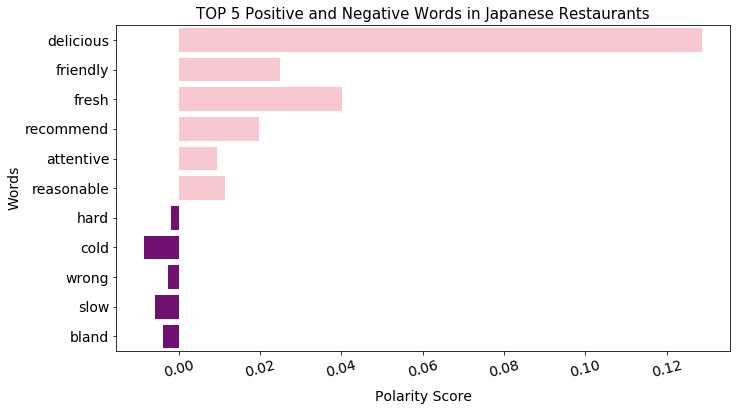

In [52]:
plt.figure(figsize=(11,6))
colors = ['purple' if c < 0 else 'pink' for c in Japanese5top.values]
sns.barplot(y=Japanese5top.index, x=Japanese5top.values, palette=colors)
plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('TOP 5 Positive and Negative Words in Japanese Restaurants', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)

## *Helper function that we used are listed below*

In [23]:


def get_polarity_score(dataset):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_train=list(dataset['text'])
    class_train=list(dataset['labels'])
    
    ## get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(terms_train)
    
    ## run model
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    ## drop unnecessary words
    unuseful_positive_words = ['impressed','great','amazing','love','best','excellent','good',
                                                    'favorite','loved','gem','perfectly','wonderful','delightful',
                                                    'happy','enjoyed','nice','super','like','better','decent','fine',
                                                    'pretty','enough','excited','ready','fantastic','glad','right',
                                                    'fabulous','fun','well','fabulous','awesome','impressed']
    unuseful_negative_words =  ['bad','terrible','unfortunately','disappoint','annoyed','annoying','horrible',
                                                     'lacking','sorry', 'awful','disappointed','disappointing','angry','sad']
    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(cuisine_polarity_score.loc[unuseful_words].index, axis=0, inplace=True)
    
    return cuisine_polarity_score

    
    
def get_top_words(dataset, label, number=20):
    if label == 'positive':
        df = dataset[dataset.polarity>0].sort_values('polarity',ascending = False)[:number]
    else:
        df = dataset[dataset.polarity<0].sort_values('polarity')[:number]
    return df


## get dataset by category
def get_dataset(category):
    df = restaurants_reviews.loc[:,['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df



## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive + negative]
    words = ' '.join(words)
    return words
